## Welcome To The Tutorial 5 Of Responsible AI

#### Welcome to our tutorial on In- and Post-processing based approach to mitigate discrimination in Machine Learning

In this tutorial, we begin with exploring some popular In-processing based fairness algorithms and then later on also explore some Post-processing fairness algorithms. For practical code examples we again use the ACS-PUMS data to train the machine learning models under discussion.


**In-processing** bias mitigation algorithms are techniques applied during the training process to address biases and promote fairness within machine learning models. These algorithms aim to modify the learning process itself to ensure that the model does not unfairly favor or discriminate against particular groups. Here's an overview of some key in-processing bias mitigation algorithms:

**1. Reweighting Techniques:**
Objective: Adjust the weights of instances to balance the contribution of different groups.
Implementation: Algorithms such as the Reweighing algorithm assign higher weights to underrepresented groups, ensuring that the model pays equal attention to all demographic subgroups.

**2. Adversarial Training:**
Objective: Train the model to be invariant to sensitive attributes by introducing adversarial networks.
Implementation: Adversarial networks are added to the training process, aiming to simultaneously predict the target variable and confuse an adversary attempting to predict sensitive attributes. This encourages the model to be less dependent on sensitive features.

**9. Constrained Optimization:**
Objective: Incorporate constraints during the optimization process to explicitly enforce fairness criteria.
Implementation: Define constraints that reflect fairness requirements (e.g., demographic parity) and include them in the optimization objective during model training. Algorithms like adversarial debiasing and disparate impact remover often leverage constrained optimization.


#### Lets dive into more details by training an ML model on previously introduced ACS-PUMS data with our own defined task and filter using the folktables library

In [218]:
import folktables
from folktables import ACSDataSource

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AR"], download=True)

In [219]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score,precision_score,f1_score
import numpy as np
from fairlearn.metrics import true_positive_rate

#### Defining our own filter

In [8]:
def our_filter(data):
    df = data
    df = df[df['AGEP'] < 65]
    df = df[df['PINCP'] > 1000]
    df = df[df['WKHP'] > 2]
    df = df[df['PWGTP'] >= 1]
    return df

#### Defining our own task

In [61]:
features=[ 'AGEP','SCHL', 'MAR','DIS','ESP','CIT','MIG','MIL', 'ANC','NATIVITY','DEAR',
        'DEYE','DREM','RAC1P','PUMA', 'OCCP','JWTR','GCL','PINCP',
        'ESR', 'POWPUMA']

Hardworkers = folktables.BasicProblem(
                         features=features,
                        target='WKHP',
                        target_transform=lambda x: x > 45,
                        group='SEX',
                        preprocess=our_filter,
                        postprocess=lambda x: np.nan_to_num(x, -1),
                    )

In [109]:
features, label, group = Hardworkers.df_to_pandas(acs_data)

In [110]:
group

,SEX
0,2
1,1
2,2
3,2
4,2
...,...
12430,1
12431,1
12432,2
12433,2


#### 1: Male, 2: Female (refer to tutorial 2)

In [111]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

#### We start with the 1) Reweighting Techniques. 

We will use an ensemble method for fairness: **AdaFair: Cumulative Fairness Boosting**, modifying the data distribution throughout boosting rounds to emphasize misclassified instances of minority groups. 

To install Adafair refer to the repo: https://github.com/iosifidisvasileios/AdaFair/tree/master


After the installation I ran into some issues while loading the Adafair library. To resolve it I changed the sklearn version to 1.2.2

In [112]:
from adafair import AdaFair

**To note:** Adafair needs the data to contain the protected information, to shift the weights of the data instances. Also it assumes the class labels to be of int type, particularly 1 for positive (in our case y=True) and -1 for negative (in our case y=False). Thus we need to change the labels accordingly. 

In [113]:
X_train['sex']=group_train.copy()
X_test['sex']=group_test.copy()
sa_index=-1 #the location of the protected attribute in the data
p_Group=2 #the protected group

y_train=[1 if v==True else -1 for v in y_train['WKHP']]
classifier = AdaFair(n_estimators=200, saIndex=sa_index, saValue=p_Group, trade_off_c=1.0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

/Users/arjunroy/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

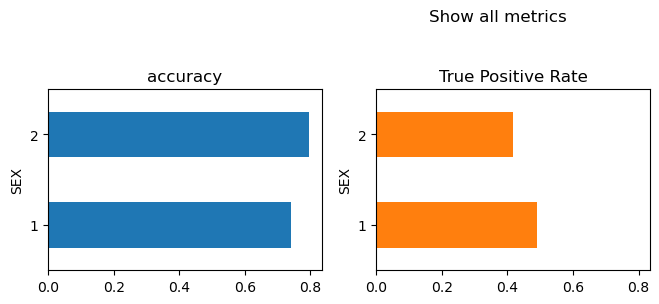

In [114]:
y_test=[1 if v==True else -1 for v in y_test['WKHP']]

metrics = {
    "accuracy": accuracy_score,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

We can see that the true positive rates are almost equal between the groups. This, is because the model in its default setting is tailored to minimize Equalized odds, thus cares about the ground truth label distribution.

**Next we move the 2) Adverserial training methods. 

Both the fairlearn and the aif360 library has the implementation of the adverserial algorithm introduced by Zhang et al. in AIES 2018. 

We will use the one from the fairlearn library, but there is no preference between fairlearn and aif360 and both the impletentation works well.

##### Adverserial fair classifier are basically implemented with a deep NN backend. Thus, one needs to have either pytorch or tensorflow installed for this. In this tutorial we will use pytorch as backend.

In [140]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

In [141]:
from fairlearn.adversarial import AdversarialFairnessClassifier

**To note:** the classifier works on top a NN architecture, which if not passed in the argument, then assumes as default a neural network without any hidden layers. However, the number of nodes in the input and output layer are automatically inferred from data, and the final activation function (such as softmax for categorical predictors) are inferred from data. It is also possible to pass a list $[k_1, k_2, \dots]$, where each $k_i$
either indicates the number of nodes (if $k_i$  is an integer) or an activation function (if $k_i$ is a string)

In [142]:
mitigator = AdversarialFairnessClassifier(
    backend="torch",
    constraints='equalized_odds',
    predictor_model=[50, "leaky_relu"],
    adversary_model=[3, "leaky_relu"],
    batch_size=2 ** 11,
    progress_updates=0.5,
    random_state=123,
)

We need to transform the data accordingly as well so that NN can process it.

In [143]:
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from numpy import number

ct = make_column_transformer(
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="mean")),
                ("normalizer", StandardScaler()),
            ]
        ),
        make_column_selector(dtype_include=number),
    ),
    (
        Pipeline(
            [
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OneHotEncoder(drop="if_binary", sparse=False)),
            ]
        ),
        make_column_selector(dtype_include="category"),
    ),
)

In [144]:
X_prep_train = ct.fit_transform(X_train) # Only fit on training data!
X_prep_test = ct.transform(X_test)

In [145]:
y_train=y_train['WKHP'].array.astype(int)

In [146]:
mitigator.fit(X_prep_train, y_train, sensitive_features=group_train)

AdversarialFairnessClassifier(adversary_model=[3, 'leaky_relu'],
                              backend='torch', batch_size=2048,
                              constraints='equalized_odds',
                              predictor_model=[50, 'leaky_relu'],
                              progress_updates=0.5, random_state=123)

In [147]:
y_pred = mitigator.predict(X_prep_test)

array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

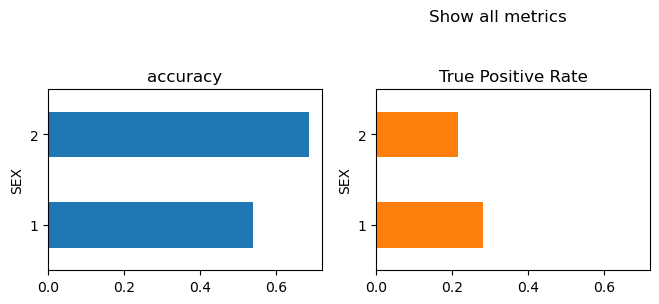

In [148]:
y_test=y_test['WKHP'].array.astype(int)

metrics = {
    "accuracy": accuracy_score,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

#### The model learns almost equal true predictions but can you still point out the problems??

The true positive rate is still not that impressive. This is because the model does not have the capacity to tackle class imbalance.

Last method we have today for our discussion on in-processing methods is **3) Constrained Optimization**.
Under this category the Exponenciated gradient Reduction algorithm introduced by Agarwal et al. in ICML 18 stands the best. The implementation of this algorithm again can be found in both **FairLearn**, and **AIF360** library. We have already seen the implementation using FairLearn in our Tutorial 1.  

Moving on let's wrap up our today's tutorial with some post-processing methods. We will use **AIF360** library this time.

Post-processing fairness methods are techniques applied after a machine learning model has been trained and has made predictions. These methods aim to mitigate bias and ensure fairness in the outcomes of the model, especially with respect to different demographic groups. Here are some post-processing fairness methods available in the aif360 library:

**1. Calibration:**
Objective: Adjust predicted probabilities to align with observed outcomes and achieve calibration across different groups.
Implementation: Calibrate model predictions to ensure that the predicted probabilities accurately reflect the true likelihood of the event, particularly for different demographic subgroups.

**2. Reject Option Classification:**
Objective: Set a rejection threshold for uncertain predictions to avoid biased outcomes.
Implementation: Reject predictions falling below a confidence threshold, preventing the model from making potentially biased or unfair predictions.

**3. Equalized Odds Postprocessing:**
Objective: Post-process model predictions to ensure equalized odds across different groups.
Implementation: Adjust predicted probabilities to achieve parity in false positive and false negative rates, promoting fairness in both classes.

The implementation of **Equalized Odds Postprocessing** we have already seen in our tutorial 1, hence will not repeat here.

For the other two let's have a look:

In [220]:
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
import aif360

In [221]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

We first initialize all the algorithms from the aif360 library and also train our basic classifier upon which we will do the post prediction corrections

In [222]:

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 2}]


calib = CalibratedEqOddsPostprocessing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)

rej = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)


classifier = DecisionTreeClassifier(min_samples_leaf=5, max_depth=15)
classifier.fit(X_train, y_train)
y_pred_train=classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

We next prepare the data we need for the post-processing algorithms

In [223]:
data_train=X_train.copy()
data_train['sex']=group_train.copy()
data_train['target']=y_train.copy()

data_train_pred=data_train.copy()
data_train_pred['target']=y_pred_train.copy()

data_test=X_test.copy()
data_test['sex']=group_test.copy()
data_test['target']=y_test.copy()

data_test_pred=data_test.copy()
data_test_pred['target']=y_pred_test.copy()


aif_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_train,
    label_names=['target'],
    protected_attribute_names=['sex'])

aif_train_pred = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_train_pred,
    label_names=['target'],
    protected_attribute_names=['sex'])


aif_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_test,
    label_names=['target'],
    protected_attribute_names=['sex'])

aif_test_pred = aif360.datasets.BinaryLabelDataset(
    favorable_label=False,
    unfavorable_label=True,
    df=data_test_pred,
    label_names=['target'],
    protected_attribute_names=['sex'])

Next we train all the post-processing methods

In [224]:
calib.fit(aif_train,aif_train_pred)
rej.fit(aif_train,aif_train_pred)

/Users/arjunroy/anaconda3/lib/python3.11/site-packages/aif360/algorithms/postprocessing/reject_option_classification.py:160: UserWarning: Unable to satisy fairness constraints
  warn("Unable to satisy fairness constraints")


Now let's see how they have actually performed in producing fair outcomes

#### For the CalibratedEqOddsPostprocessing method we have

array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

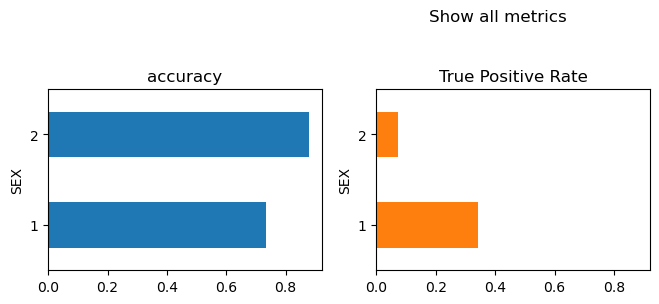

In [225]:
calib_pred=calib.predict(aif_test_pred)

metrics = {
    "accuracy": accuracy_score,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=aif_test.labels, y_pred=calib_pred.labels, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

#### For the Reject Option Classification method we have

array([[<Axes: title={'center': 'accuracy'}, ylabel='SEX'>,
        <Axes: title={'center': 'True Positive Rate'}, ylabel='SEX'>,
        <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>],
       [<Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>, <Axes: ylabel='SEX'>]],
      dtype=object)

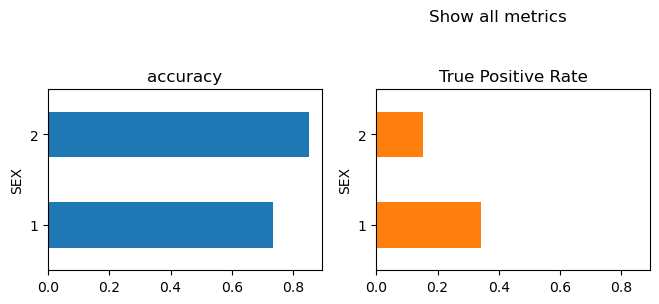

In [226]:
rej_pred=rej.predict(aif_test_pred)

metrics = {
    "accuracy": accuracy_score,
    "True Positive Rate": true_positive_rate
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=aif_test.labels, y_pred=rej_pred.labels, sensitive_features=group_test
)
metric_frame.by_group.plot.barh(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

### So we see that the in-processing methods in general have better predictive outcomes than the post-processing, as post-processing algorithms are limited to the predictive capacity of the base classifiers.   

That's all for today, hope you enjoyed the session and learned something interesting today.

### References

- Bellamy, R. K., Dey, K., Hind, M., Hoffman, S. C., Houde, S., Kannan, K., ... & Zhang, Y. (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv preprint arXiv:1810.01943.

- R. Zemel, Y. Wu, K. Swersky, T. Pitassi, and C. Dwork, “Learning Fair Representations.” International Conference on Machine Learning, 2013.

- G. Pleiss, M. Raghavan, F. Wu, J. Kleinberg, and K. Q. Weinberger, “On Fairness and Calibration,” Conference on Neural Information Processing Systems, 2017

- F. Kamiran, A. Karim, and X. Zhang, “Decision Theory for Discrimination-Aware Classification,” IEEE International Conference on Data Mining, 2012.

- B. H. Zhang, B. Lemoine, and M. Mitchell, “Mitigating Unwanted Biases with Adversarial Learning,” AAAI/ACM Conference on Artificial Intelligence, Ethics, and Society, 2018.

- Iosifidis, V., Roy, A., & Ntoutsi, E. (2022). Parity-based cumulative fairness-aware boosting. Knowledge and Information Systems, 64(10), 2737-2770.